## Training with label smoothing

### Data generation

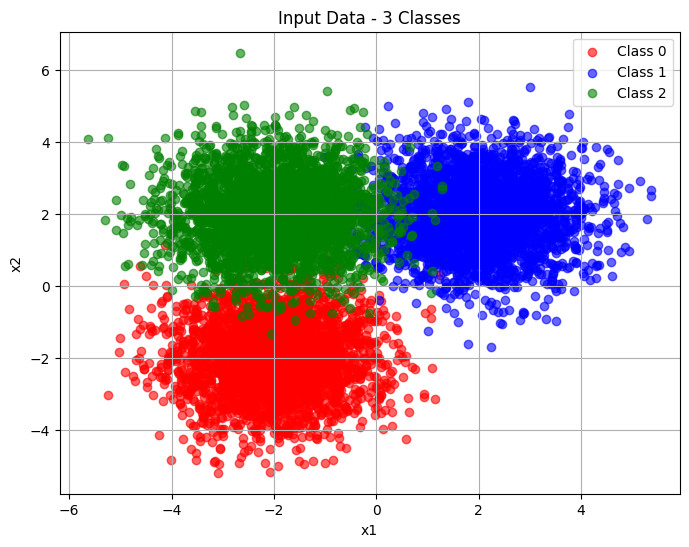

In [131]:
# Data Generation and Visualization
import numpy as np
import torch
import torch.nn.functional as F
import matplotlib.pyplot as plt

# 1. Generate 2D Gaussian data with 3 clusters
np.random.seed(42)
n_samples_per_class = 3000
n_classes = 3
n_features = 2

# Generate data for each cluster
X = []
y = []
means = [[-2, -2], [2, 2], [-2, 2]]
noise_scale = 1.0  # Increased noise
for i in range(n_classes):
    X_i = np.random.randn(n_samples_per_class, n_features) * noise_scale + means[i]
    X.append(X_i)
    y.append(np.full(n_samples_per_class, i))

# Stack and reshape X to be [n_features, n_samples]
X = np.vstack(X)          # Shape: [n_samples, n_features]
X = X.T                   # Shape: [n_features, n_samples]
y = np.hstack(y)         # Shape: [n_samples]

# Convert to one-hot encoding [n_classes, n_samples]
y_onehot = np.zeros((n_classes, len(y)))
y_onehot[y, np.arange(len(y))] = 1

# Apply label smoothing
smoothing = 0.1
y_onehot_smooth = y_onehot * (1 - smoothing) + (smoothing / n_classes)

# Visualization of input data
plt.figure(figsize=(8, 6))
colors = ['red', 'blue', 'green']
for i in range(n_classes):
    mask = y == i
    plt.scatter(X[0,mask], X[1,mask], color=colors[i], label=f'Class {i}', alpha=0.6)
plt.xlabel("x1")
plt.ylabel("x2")
plt.legend()
plt.title("Input Data - 3 Classes")
plt.grid(True)
plt.show()


### Training utilities

In [132]:

def softmax(z):
    exp_z = np.exp(z - np.max(z, axis=0, keepdims=True))
    return exp_z / np.sum(exp_z, axis=0, keepdims=True)

def forward(W, b, X):
    # W: [3, 2], X: [2, n_samples] -> z: [3, n_samples]
    z = W @ X + b
    return softmax(z)

def cross_entropy_loss(probs, y_true):
    return -np.mean(np.sum(y_true * np.log(probs + 1e-10), axis=0))

def compute_gradients(X, probs, y_true):
    m = X.shape[1]  # number of examples
    dz = probs - y_true  # [3, n_samples]
    dW = (dz @ X.T) / m  # [3, n_samples] @ [2, n_samples].T -> [3, 2]
    db = np.mean(dz, axis=1, keepdims=True)  # [3, 1]
    return dW, db

def train_model(X, y_labels, W_init, b_init, lr=0.1, epochs=1000):
    W = W_init.copy()
    b = b_init.copy()
    losses = []
    
    for epoch in range(epochs):
        probs = forward(W, b, X)
        loss = cross_entropy_loss(probs, y_labels)
        dW, db = compute_gradients(X, probs, y_labels)
        W -= lr * dW
        b -= lr * db
        losses.append(loss)
    
    return W, b, losses


### Training (numerical gradients)

In [133]:

# Initialize parameters
np.random.seed(42)
W_init = np.random.randn(n_classes, n_features) * 0.01
b_init = np.zeros((n_classes, 1))
lr = 0.1
epochs = 1000

# Train models with and without label smoothing
W_standard, b_standard, loss_standard = train_model(X, y_onehot, W_init, b_init)
W_smooth, b_smooth, loss_smooth = train_model(X, y_onehot_smooth, W_init, b_init)



### Training (PyTorch)

In [134]:
X_torch = torch.tensor(X, dtype=torch.float32)
y_torch = torch.tensor(y, dtype=torch.long)

# Train standard model
W_torch = torch.tensor(W_init, dtype=torch.float32, requires_grad=True)
b_torch = torch.tensor(b_init, dtype=torch.float32, requires_grad=True)
criterion_standard = torch.nn.CrossEntropyLoss()
loss_torch_standard = []

for epoch in range(epochs):
    z = W_torch @ X_torch + b_torch
    loss = criterion_standard(z.T, y_torch)
    loss_torch_standard.append(loss.item())
    loss.backward()
    with torch.no_grad():
        W_torch -= lr * W_torch.grad
        b_torch -= lr * b_torch.grad
    W_torch.grad.zero_()
    b_torch.grad.zero_()

# Train smoothed model
W_torch_smooth = torch.tensor(W_init, dtype=torch.float32, requires_grad=True)
b_torch_smooth = torch.tensor(b_init, dtype=torch.float32, requires_grad=True)
criterion_smooth = torch.nn.CrossEntropyLoss(label_smoothing=smoothing)
loss_torch_smooth = []

for epoch in range(epochs):
    z = W_torch_smooth @ X_torch + b_torch_smooth
    loss = criterion_smooth(z.T, y_torch)
    loss_torch_smooth.append(loss.item())
    loss.backward()
    with torch.no_grad():
        W_torch_smooth -= lr * W_torch_smooth.grad
        b_torch_smooth -= lr * b_torch_smooth.grad
    W_torch_smooth.grad.zero_()
    b_torch_smooth.grad.zero_()


### Training loss

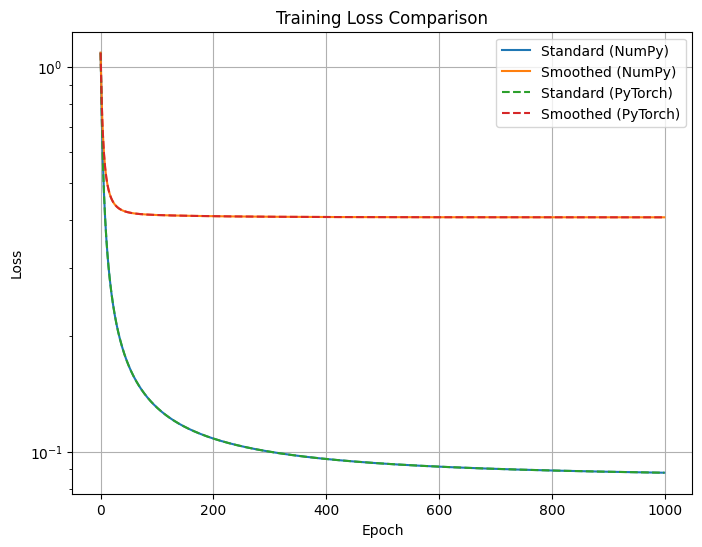

In [135]:

# Plotting
plt.figure(figsize=(8, 6))

# Plot 1: Training Losses
plt.semilogy(loss_standard, label='Standard (NumPy)')
plt.semilogy(loss_smooth, label='Smoothed (NumPy)')
plt.semilogy(loss_torch_standard, '--', label='Standard (PyTorch)')
plt.semilogy(loss_torch_smooth, '--', label='Smoothed (PyTorch)')
plt.title("Training Loss Comparison")
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.legend()
plt.grid(True)
plt.show()


### Decision boundaries

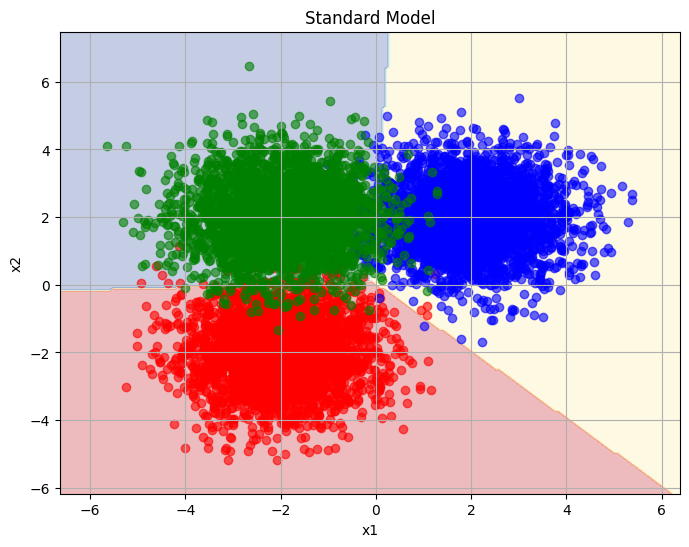

In [136]:

# Prepare grid for decision boundaries
x_min, x_max = X[0].min() - 1, X[0].max() + 1
y_min, y_max = X[1].min() - 1, X[1].max() + 1
xx, yy = np.meshgrid(np.linspace(x_min, x_max, 200),
                     np.linspace(y_min, y_max, 200))
X_grid = np.c_[xx.ravel(), yy.ravel()].T

# Plot 2: Standard Model Decision Boundaries
plt.figure(figsize=(8, 6))
probs_standard = forward(W_standard, b_standard, X_grid)
pred_standard = np.argmax(probs_standard, axis=0)
plt.contourf(xx, yy, pred_standard.reshape(xx.shape), alpha=0.3, cmap='RdYlBu')
for i in range(n_classes):
    mask = y == i
    plt.scatter(X[0,mask], X[1,mask], color=colors[i], label=f'Class {i}', alpha=0.6)
plt.xlabel("x1")
plt.ylabel("x2")
plt.title("Standard Model")
plt.grid(True)
plt.show()


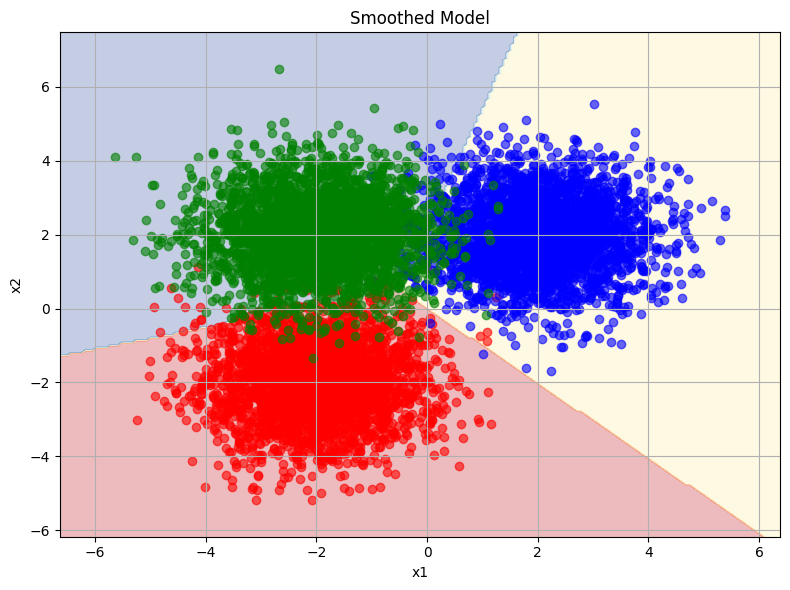

In [137]:

# Plot 3: Smoothed Model Decision Boundaries
plt.figure(figsize=(8, 6))
probs_smooth = forward(W_smooth, b_smooth, X_grid)
pred_smooth = np.argmax(probs_smooth, axis=0)
plt.contourf(xx, yy, pred_smooth.reshape(xx.shape), alpha=0.3, cmap='RdYlBu')
for i in range(n_classes):
    mask = y == i
    plt.scatter(X[0,mask], X[1,mask], color=colors[i], label=f'Class {i}', alpha=0.6)
plt.xlabel("x1")
plt.ylabel("x2")
plt.title("Smoothed Model")
plt.grid(True)

plt.tight_layout()
plt.show()


In [138]:
# Get predictions for both models
pred_standard = np.argmax(forward(W_standard, b_standard, X), axis=0)
pred_smooth = np.argmax(forward(W_smooth, b_smooth, X), axis=0)

# Calculate misclassification rates
error_standard = np.mean(pred_standard != y)
error_smooth = np.mean(pred_smooth != y)

print("\nMisclassification Rates:")
print(f"Standard Model: {error_standard:.3%}")
print(f"Smoothed Model: {error_smooth:.3%}")



Misclassification Rates:
Standard Model: 3.256%
Smoothed Model: 3.556%
